<a href="https://colab.research.google.com/github/gabmachado97/jetson_segmentation/blob/main/hrnet_w18_fastai_2stages_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dependencies




In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
!/opt/bin/nvidia-smi
!nvcc --version

Sat Oct  9 14:24:25 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install fastai==2.3.0
!pip install lapixdl==0.7.15
!pip install -U albumentations
!pip install SemTorch
!pip install onnx
!pip install onnxruntime

     |████████████████████████████████| 193 kB 4.1 MB/s 
     |████████████████████████████████| 56 kB 2.7 MB/s 
     |████████████████████████████████| 776.8 MB 17 kB/s 
     |████████████████████████████████| 12.8 MB 24 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.9.0+cu111
    Uninstalling torch-1.9.0+cu111:
      Successfully uninstalled torch-1.9.0+cu111
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.10.0+cu111
    Uninstalling torchvision-0.10.0+cu111:
      Successfully uninstalled torchvision-0.10.0+cu111
  Attempting uninstall: fastai
    Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.10.0 requires torch==1.9.0, but you have torch 1.7.1 which is incompati

In [ ]:
from pathlib import Path
import fnmatch
import random
import shutil
import numpy as np
from scipy.io import savemat
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from fastai.vision.all import *

import albumentations as A
import cv2

from lapixdl.evaluation.visualize import show_segmentations
from lapixdl.evaluation.model import Result

import torch
import torch.onnx

# SemTorch
from semtorch import get_segmentation_learner

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Drive Path

In [ ]:
path = Path('/content/drive/MyDrive/Mestrado/Segmentação/data/HRNet_Data')
path_train_lbl = path/'train_labels_ids' 
path_train_img = path/'train'
path_val_lbl = path/'val_labels_ids' 
path_val_img = path/'val'

#update this path in the next test
path_models = path/'Models/weighted_unet_resnet_34'
path_results = path/'Results/weighted_unet_resnet_34'

In [ ]:
codes = np.loadtxt(path/'codes.txt', dtype=str)
print(codes)
len(codes)

['background' 'roadAsphalt' 'roadPaved' 'roadUnpaved' 'roadMarking'
 'speedBump' 'catsEye' 'stormDrain' 'manholeCover' 'patches' 'waterPuddle'
 'pothole' 'cracks']


13

# Pre processing of data

In [ ]:
get_y_fn = lambda x: path_lbl/f'{x.stem}{x.suffix}'

In [ ]:
fnames = get_image_files(path, folders=['train', 'val'])

get_mask = lambda x: PILMask.create((path_train_lbl if x.parent.name == 'train' else path_val_lbl)/f'{x.stem}{x.suffix}')
mask = PILMask.create(get_mask(fnames[1]))
src_size = np.array(mask.shape)
src_size

array([288, 352])

In [ ]:
# Baseado no gráfico de distribuição de classes: https://www.mucar3.de/icpr2020-tas500/images/barchart.png
# w ~= [n_pixels_asfalto]/[n_pixels_classe]
class_weights = torch.tensor([
  1.0,
  5.0,
  6.0,
  7.0,
  75.0,
  1000.0,
  3100.0,
  3300.0,
  0.0,
  270.0,
  2200.0,
  1000.0,
  180.0 
]).cuda()

In [ ]:
rgb_to_hex = '#%02x%02x%02x'
cmap = [
  "#{0:02x}{1:02x}{2:02x}".format(0,0,0), #background
  "#{0:02x}{1:02x}{2:02x}".format(85,170,127), #roadPaved
  "#{0:02x}{1:02x}{2:02x}".format(255,170,127), ##roadUnpaved
  "#{0:02x}{1:02x}{2:02x}".format(255,255,255), #roadMarking
  "#{0:02x}{1:02x}{2:02x}".format( 255,85,255), #speedBump
  "#{0:02x}{1:02x}{2:02x}".format( 255,255,127), #catsEye
  "#{0:02x}{1:02x}{2:02x}".format(170,0,127), #stormDrain
  "#{0:02x}{1:02x}{2:02x}".format( 0,255,255), #manholeCover
  "#{0:02x}{1:02x}{2:02x}".format(0,0, 27), #patchs
  "#{0:02x}{1:02x}{2:02x}".format(170,0,0), #waterPuddle
  "#{0:02x}{1:02x}{2:02x}".format(255,0,0), #pothole
  "#{0:02x}{1:02x}{2:02x}".format( 255,85,0), #cracks
]
cmap

['#000000',
 '#55aa7f',
 '#ffaa7f',
 '#ffffff',
 '#ff55ff',
 '#ffff7f',
 '#aa007f',
 '#00ffff',
 '#00001b',
 '#aa0000',
 '#ff0000',
 '#ff5500']

# Data Analysis

In [ ]:
test_fnames = list(filter(lambda fname: Path(fname).parent.name != 'val', fnames))
val_fnames = list(filter(lambda fname: Path(fname).parent.name == 'val', fnames))

print(f'Train: {len(test_fnames)}')
print(f'Validation: {len(val_fnames)}')
print(f'Total: {len(fnames)}')

Train: 592
Validation: 140
Total: 732


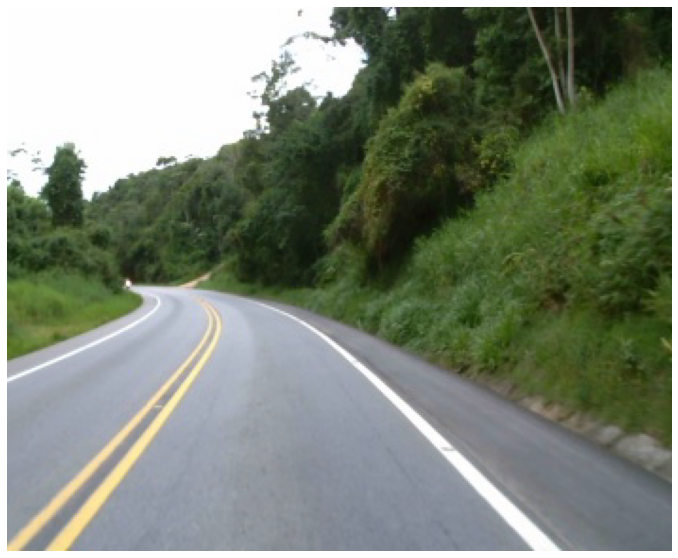

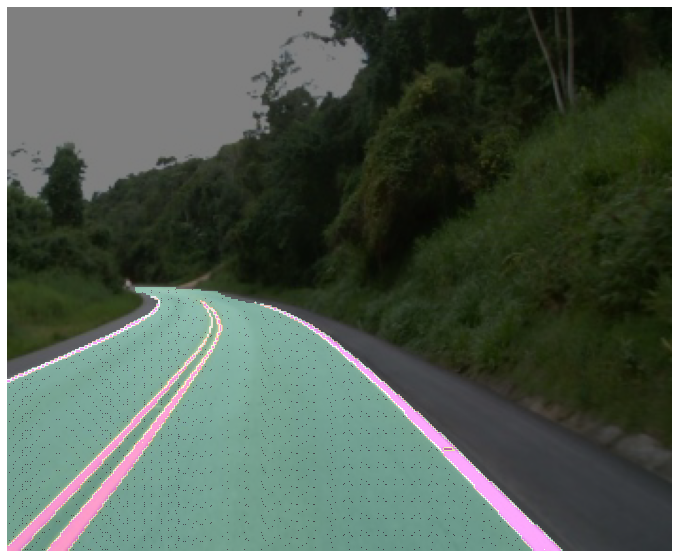

In [ ]:
img_f = fnames[random.randint(0, len(fnames) - 1)]

img = PILImage.create(img_f)
mask = get_mask(img_f)

# show_segmentations([Result(img, mask)], codes, cmap=ListedColormap(cmap))

img.show(figsize=(20,10))
ax = img.show(figsize=(20,10))
mask.show(ctx=ax, figsize=(20,10), cmap=ListedColormap(cmap), vmax=len(cmap))

# Metrics, augmentations, data split and model definition 

Piece taken from shared driver

In [ ]:
class SegmentationAlbumentationsTransform(ItemTransform):
    split_idx = 0 #Train only
    def __init__(self, aug): self.aug = aug
    def encodes(self, x):
        img,mask = x
        aug = self.aug(image=np.array(img), mask=np.array(mask))
        return PILImage.create(aug["image"]), PILMask.create(aug["mask"])

class ImageResizer(Transform):
    order=1
    "Resize image to `size` using `resample`"
    def __init__(self, size, resample=Image.BILINEAR):
        if not is_listy(size): size=(size,size)
        self.size,self.resample = (size[1],size[0]),resample

    def encodes(self, o:PILImage): return o.resize(size=self.size, resample=self.resample)
    def encodes(self, o:PILMask):  return o.resize(size=self.size, resample=Image.NEAREST)

augmentations = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(0.1, 0.1, p=0.75),
])

In [ ]:
tfms = [[PILImage.create], [get_mask, AddMaskCodes(codes)]]
folder_split = FuncSplitter(lambda fname: Path(fname).parent.name == 'val')
src = Datasets(fnames, tfms, splits=folder_split(fnames))

In [ ]:
class DiceMulti(Metric):
    "Averaged Dice metric (Macro F1) for multiclass target in segmentation"
    def __init__(self, axis=1): self.axis = axis
    def reset(self): self.inter,self.union,self.total_area = {},{},{}
    def accumulate(self, learn):
        pred,targ = flatten_check(learn.pred.argmax(dim=self.axis), learn.y)
        for c in range(learn.pred.shape[self.axis]):
            p = torch.where(pred == c, 1, 0)
            t = torch.where(targ == c, 1, 0)
            c_inter = (p*t).float().sum().item()
            c_totalSumAreas = (p+t).float().sum().item()
            c_union = c_totalSumAreas-c_inter
            if c in self.inter:
                self.inter[c] += c_inter
                self.total_area[c] += c_totalSumAreas
                self.union[c] += c_union
            else:
                self.inter[c] = c_inter
                self.total_area[c] = c_totalSumAreas
                self.union[c] = c_union
    @property
    def value(self):
        binary_dice_scores = np.array([])
        for c in self.inter:
            binary_dice_scores = np.append(binary_dice_scores, 2.*self.inter[c]/self.total_area[c] if self.total_area[c] > 0 else np.nan)
        return np.nanmean(binary_dice_scores)

class JaccardCoeffMulti(DiceMulti):
  "Implementation of the Averaged Jaccard coefficient that is lighter in RAM -- Mean IoU (Intersection Over Union)"
  @property
  def value(self): 
    binary_jaccard_scores = np.array([])
    for c in self.inter:
        binary_jaccard_scores = np.append(binary_jaccard_scores, self.inter[c]/self.union[c] if self.union[c] > 0 else np.nan)
    return np.nanmean(binary_jaccard_scores)

name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['manholeCover']
def acc_rtk(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

iou_metric = JaccardCoeffMulti()

f1_metric = DiceMulti()

metrics = [acc_rtk, iou_metric, f1_metric]

# Training

## Definitions

In [ ]:
size = src_size
bs = 4
transforms = [
  ImageResizer((size[0], size[1])), 
  SegmentationAlbumentationsTransform(augmentations), 
  ToTensor(), 
  IntToFloatTensor()
]
print(size)

[288 352]


Split for hrnet architecture

In [ ]:
def hrnet_splitter(model):
    return [params(model.backbone), params(model.head)]

In [ ]:
data = src.dataloaders(bs=bs, after_item=transforms)

# data.show_batch(max_n=6)

def get_learner(load_modelo=None, weights=None):

  #Feito inicialmente com definições fixas para teste
  learn = get_segmentation_learner(dls=data, number_classes=13, segmentation_type="Semantic Segmentation",
                                 architecture_name="hrnet", backbone_name="hrnet_w18", 
                                 metrics=metrics, wd=1e-2,
                                 splitter=hrnet_splitter, pretrained=True,
                                 loss_func=CrossEntropyLossFlat(axis=1, weight=weights)).to_fp16()

  learn.path = path_models
  if(load_modelo != None):
    learn = learn.load(load_modelo,with_opt=False)
    #learn.summary
    #learn = get_segmentation_learner(dls=data, number_classes=13, segmentation_type="Semantic Segmentation",
    #                             architecture_name="hrnet", backbone_name="hrnet_w18", 
    #                             metrics=metrics, wd=1e-2, cbs=callb,
    #                             splitter=hrnet_splitter, pretrained=True,
    #                             loss_func=CrossEntropyLossFlat(axis=1, weight=class_weights)).to_fp16()

  return learn

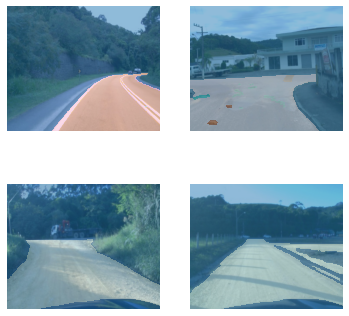

In [ ]:
data.show_batch(max_n=9)

## 1º Stage (no balanced weights)

### 1º Step (Freeze)

100%|██████████| 83749/83749 [00:02<00:00, 38281.12KB/s]


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


SuggestedLRs(lr_min=0.2754228591918945, lr_steep=2.290867567062378)

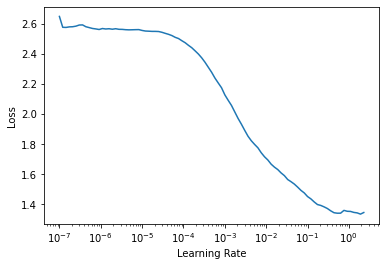

In [ ]:
get_learner().lr_find()

In [ ]:
lr=slice(1e-3)
wd=1e-3
learn = get_learner()
callback = SaveModelCallback(monitor='acc_rtk', fname='stg1')

learn.fit_one_cycle(5, lr_max=lr, wd=wd, cbs=callback)

epoch,train_loss,valid_loss,acc_rtk,jaccard_coeff_multi,dice_multi,time
0,0.521903,0.739385,0.915138,0.280769,0.327858,03:46
1,0.166116,0.217038,0.938944,0.319634,0.360199,03:21
2,0.094938,0.106696,0.966977,0.381416,0.424902,03:21
3,0.063403,0.078916,0.974203,0.402687,0.445131,03:20
4,0.055481,0.075662,0.974817,0.405908,0.449273,03:19


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Better model found at epoch 0 with acc_rtk value: 0.9151384830474854.
Better model found at epoch 1 with acc_rtk value: 0.9389444589614868.
Better model found at epoch 2 with acc_rtk value: 0.9669767022132874.
Better model found at epoch 3 with acc_rtk value: 0.9742034077644348.
Better model found at epoch 4 with acc_rtk value: 0.9748172163963318.


### 2º Step (Unfreeze)

In [ ]:
learn.unfreeze()

learn.fit_one_cycle(20, lr_max=lr, wd=wd, cbs=callback)

epoch,train_loss,valid_loss,acc_rtk,jaccard_coeff_multi,dice_multi,time
0,0.050975,0.073169,0.975640,0.411874,0.456549,03:20
1,0.049829,0.073074,0.975420,0.438588,0.495210,03:18
2,0.056537,0.139185,0.955195,0.460634,0.541437,03:18
3,0.060051,0.075371,0.974281,0.541350,0.638494,03:19
4,0.052178,0.085587,0.973020,0.517772,0.612016,03:17
5,0.041933,0.066963,0.978245,0.552979,0.649092,03:17
6,0.043559,0.070512,0.976493,0.588808,0.695058,03:17
7,0.035656,0.059840,0.980100,0.622423,0.730695,03:16
8,0.030357,0.063862,0.979096,0.528209,0.622082,03:16
9,0.030498,0.067673,0.978917,0.614487,0.723081,03:17


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Better model found at epoch 0 with acc_rtk value: 0.9756398797035217.
Better model found at epoch 5 with acc_rtk value: 0.9782454371452332.
Better model found at epoch 7 with acc_rtk value: 0.9801004528999329.
Better model found at epoch 11 with acc_rtk value: 0.9825882911682129.
Better model found at epoch 13 with acc_rtk value: 0.9829753041267395.
Better model found at epoch 14 with acc_rtk value: 0.9837100505828857.
Better model found at epoch 16 with acc_rtk value: 0.9838389754295349.
Better model found at epoch 17 with acc_rtk value: 0.9840739369392395.
Better model found at epoch 19 with acc_rtk value: 0.9841030836105347.


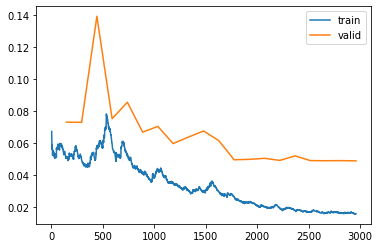

In [ ]:
learn.recorder.plot_loss()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


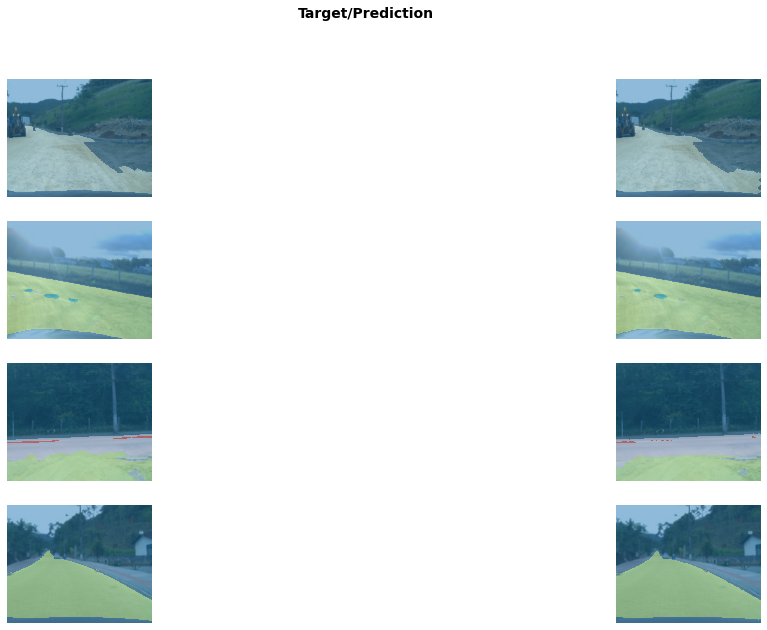

In [ ]:
learn.show_results(figsize=(20,10))

## 2º Stage (with balanced weights)

### 1ª Step (Freeze)

In [ ]:
lr = slice(1e-5,1e-3)
wd=1e-3
#learn = get_learner('best_model_155x506_stg1', True)
#get_learner('stg1',callb=callback).lr_find()
learn = get_learner('stg1', class_weights)
callback = SaveModelCallback(monitor='acc_rtk', fname='stg2')

learn.fit_one_cycle(5, lr_max=lr, wd=wd, cbs=callback)

epoch,train_loss,valid_loss,acc_rtk,jaccard_coeff_multi,dice_multi,time
0,0.072525,0.297526,0.977101,0.580390,0.690938,03:17
1,0.056452,0.289695,0.976649,0.553969,0.655702,03:17
2,0.047514,0.302402,0.977058,0.585938,0.692654,03:18
3,0.040348,0.273168,0.976884,0.589761,0.698564,03:16
4,0.036411,0.261083,0.976915,0.586788,0.695820,03:17


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Better model found at epoch 0 with acc_rtk value: 0.9771010279655457.


### 2ª Step (Unfreeze)

In [ ]:
learn.unfreeze()

learn.fit_one_cycle(20, lr_max=lr, wd=wd, cbs=callback)

epoch,train_loss,valid_loss,acc_rtk,jaccard_coeff_multi,dice_multi,time
0,0.052675,0.253539,0.976290,0.574824,0.682401,03:18
1,0.045940,0.252277,0.976217,0.576571,0.685762,03:17
2,0.044654,0.324830,0.977119,0.609764,0.721005,03:16
3,0.051618,0.336970,0.977771,0.594681,0.700618,03:18
4,0.052940,0.351072,0.977496,0.601040,0.710956,03:18
5,0.044883,0.276411,0.973058,0.541306,0.647129,03:17
6,0.039776,0.374461,0.977706,0.628549,0.740747,03:18
7,0.038906,0.346894,0.977266,0.613922,0.725197,03:17
8,0.039266,0.364635,0.976913,0.604996,0.721014,03:16
9,0.041028,0.371355,0.978388,0.622482,0.733538,03:17


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Better model found at epoch 0 with acc_rtk value: 0.9762899279594421.
Better model found at epoch 2 with acc_rtk value: 0.9771194458007812.
Better model found at epoch 3 with acc_rtk value: 0.9777711033821106.
Better model found at epoch 9 with acc_rtk value: 0.9783883094787598.
Better model found at epoch 11 with acc_rtk value: 0.9784126281738281.
Better model found at epoch 13 with acc_rtk value: 0.9794960021972656.


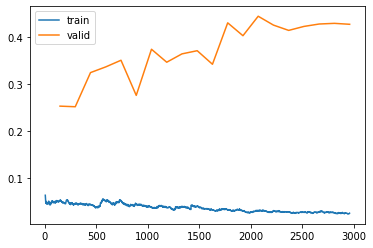

In [ ]:
learn.recorder.plot_loss()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


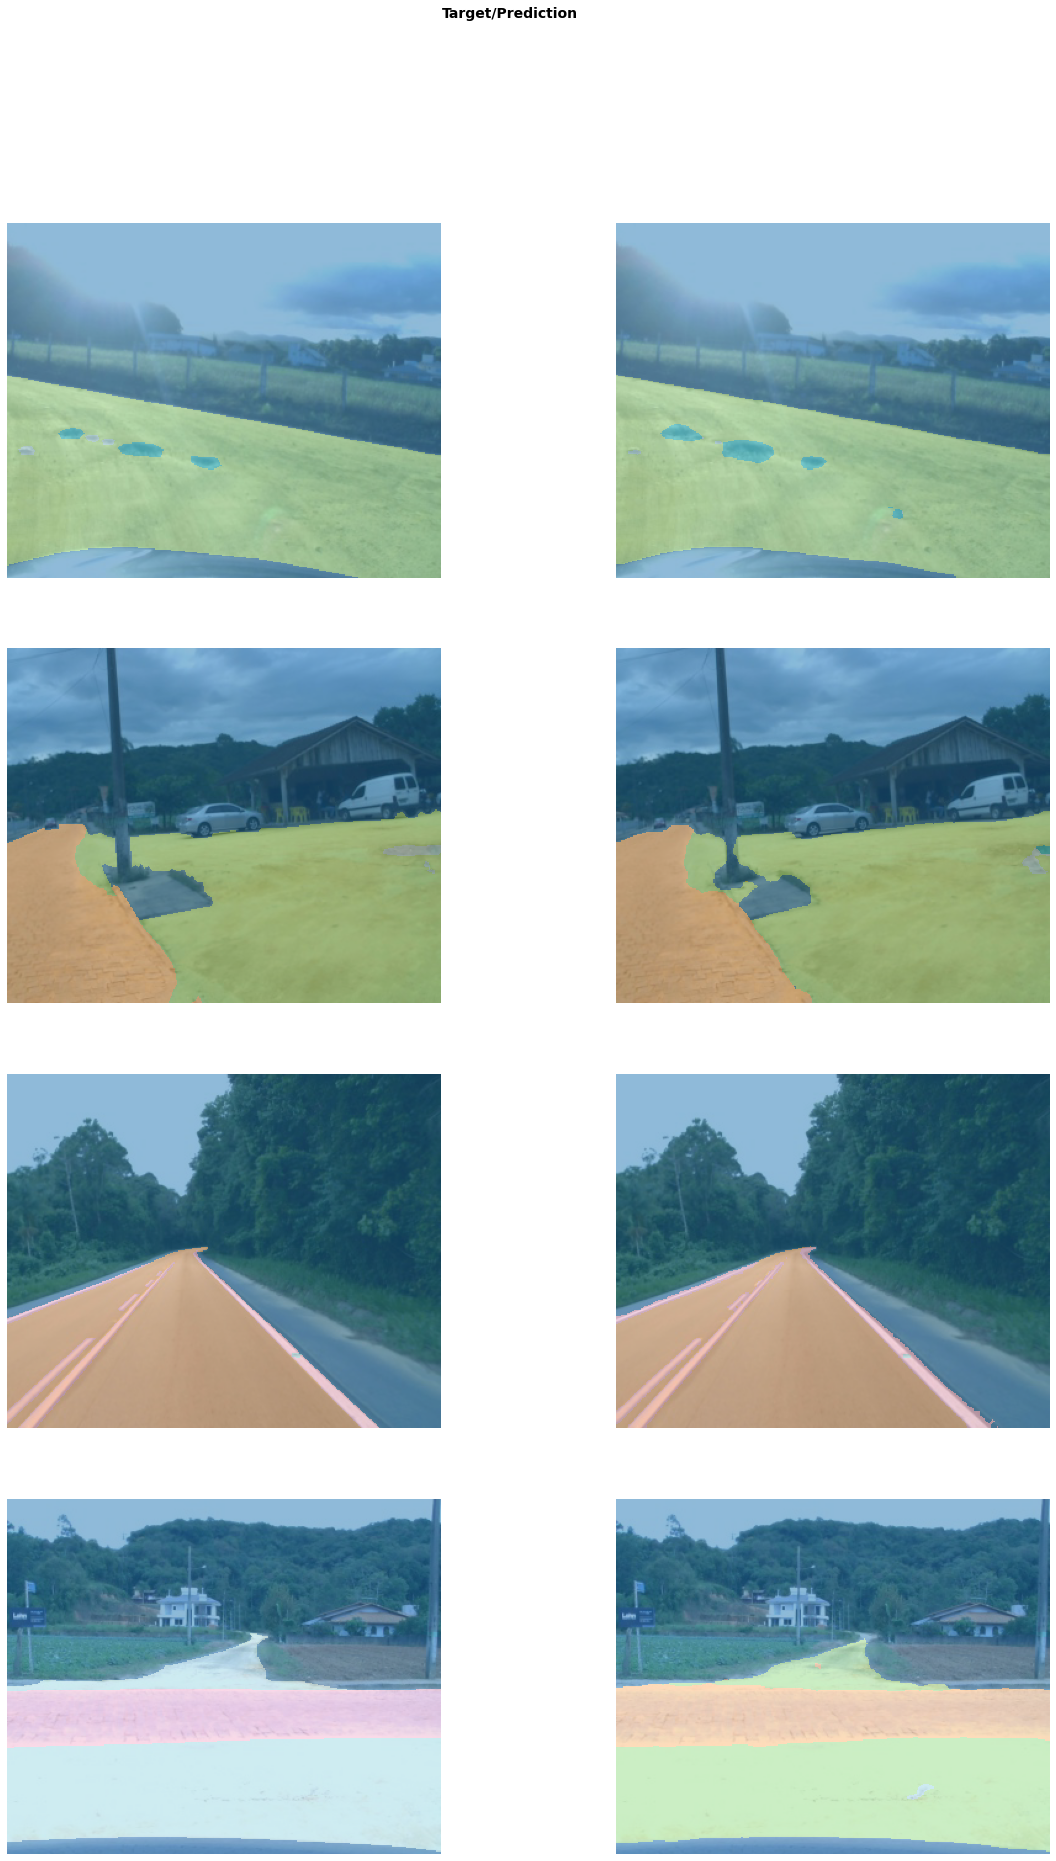

In [ ]:
learn.show_results(figsize=(20,30))

In [ ]:
learn.export('/content/drive/MyDrive/Mestrado/Segmentação/IPM/model/hrnetw18.pkl')

PicklingError: ignored

# Lapix Evaluation

In [ ]:
from lapixdl.evaluation.evaluate import evaluate_segmentation

def gt_mask_iterator_from_dl(dl):
  for img, mask in iter(dl):
    yield np.array(mask)

def pred_mask_iterator_from_dl(dl, predict):
  for img, mask in iter(dl):
    yield np.array(predict(img))

In [ ]:
size = src_size
learn = get_learner('stg2')

val_image_files = get_image_files(path_val_img)
transforms = [
  ToTensor(), 
  IntToFloatTensor()
]

val_src = Datasets(val_image_files, tfms)

0 masks [00:00, ? masks/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: Mean of empty slice
1 masks [00:00,  1.31 masks/s]

2 masks [00:01,  2.11 masks/s]

3 masks [00:01,  2.61 masks/s]

4 masks [00:01,  2.95 masks/s]

5 masks [00:01,  3.17 masks/s]

6 masks [00:02,  3.33 masks/s]

7 masks [00:02,  3.47 masks/s]

8 masks [00:02,  3.50 masks/s]

9 masks [00:02,  3.56 masks/s]

10 masks [00:03,  3.60 masks/s]

11 masks [00:03,  3.61 masks/s]

12 masks [00:03,  3.61 masks/s]

13 masks [00:04,  3.56 masks/s]

14 masks [00:04,  3.60 masks/s]

15 masks [00:04,  3.62 masks/s]

16 masks [00:04,  3.65 masks/s]

17 masks [00:05,  3.67 masks/s]

18 masks [00:05,  3.69 masks/s]

19 masks [00:05,  3.72 masks/s]

20 masks [00:05,  3.71 masks/s]

21 masks [00:06,  3.72 masks/s]

22 masks [00:06,  3.74 masks/s]

23 masks [00:06,  3.71 masks/s]

24 masks [00:07,  3.72 masks/s]

25 masks [00:07,  3.73 masks/s]

26 masks [00:07,  3.76 masks/s]

27 masks [00:07,  3.75 masks/s]

28 masks [00:08,  3.77 masks/s]

29 masks [00:08,  3.77 masks/s]

30 masks [00:08,  3.76 masks/s]

31 masks [00:08,  3.70 masks/s]

32 masks [00:09,  3.72 masks/s]

33 masks [00:09,  3.76 masks/s]

34 masks [00:09,  3.74 masks/s]

35 masks [00:09,  3.72 masks/s]

36 masks [00:10,  3.75 masks/s]

37 masks [00:10,  3.68 masks/s]

38 masks [00:10,  3.62 masks/s]

39 masks [00:11,  3.65 masks/s]

40 masks [00:11,  3.65 masks/s]

41 masks [00:11,  3.64 masks/s]

42 masks [00:11,  3.67 masks/s]

43 masks [00:12,  3.68 masks/s]

44 masks [00:12,  3.68 masks/s]

45 masks [00:12,  3.66 masks/s]

46 masks [00:12,  3.63 masks/s]

47 masks [00:13,  3.67 masks/s]

48 masks [00:13,  3.68 masks/s]

49 masks [00:13,  3.68 masks/s]

50 masks [00:14,  3.66 masks/s]

51 masks [00:14,  3.70 masks/s]

52 masks [00:14,  3.71 masks/s]

53 masks [00:14,  3.74 masks/s]

54 masks [00:15,  3.69 masks/s]

55 masks [00:15,  3.70 masks/s]

56 masks [00:15,  3.69 masks/s]

57 masks [00:15,  3.65 masks/s]

58 masks [00:16,  3.62 masks/s]

59 masks [00:16,  3.55 masks/s]

60 masks [00:16,  3.53 masks/s]

61 masks [00:17,  3.55 masks/s]

62 masks [00:17,  3.60 masks/s]

63 masks [00:17,  3.66 masks/s]

64 masks [00:17,  3.71 masks/s]

65 masks [00:18,  3.69 masks/s]

66 masks [00:18,  3.71 masks/s]

67 masks [00:18,  3.74 masks/s]

68 masks [00:18,  3.68 masks/s]

69 masks [00:19,  3.67 masks/s]

70 masks [00:19,  3.68 masks/s]

71 masks [00:19,  3.68 masks/s]

72 masks [00:20,  3.67 masks/s]

73 masks [00:20,  3.72 masks/s]

74 masks [00:20,  3.71 masks/s]

75 masks [00:20,  3.72 masks/s]

76 masks [00:21,  3.61 masks/s]

77 masks [00:21,  3.64 masks/s]

78 masks [00:21,  3.65 masks/s]

79 masks [00:21,  3.66 masks/s]

80 masks [00:22,  3.66 masks/s]

81 masks [00:22,  3.66 masks/s]

82 masks [00:22,  3.69 masks/s]

83 masks [00:23,  3.67 masks/s]

84 masks [00:23,  3.69 masks/s]

85 masks [00:23,  3.68 masks/s]

86 masks [00:23,  3.64 masks/s]

87 masks [00:24,  3.64 masks/s]

88 masks [00:24,  3.67 masks/s]

89 masks [00:24,  3.67 masks/s]

90 masks [00:24,  3.67 masks/s]

91 masks [00:25,  3.62 masks/s]

92 masks [00:25,  3.65 masks/s]

93 masks [00:25,  3.66 masks/s]

94 masks [00:26,  3.65 masks/s]

95 masks [00:26,  3.65 masks/s]

96 masks [00:26,  3.65 masks/s]

97 masks [00:26,  3.64 masks/s]

98 masks [00:27,  3.66 masks/s]

99 masks [00:27,  3.68 masks/s]

100 masks [00:27,  3.70 masks/s]

101 masks [00:27,  3.64 masks/s]

102 masks [00:28,  3.65 masks/s]

103 masks [00:28,  3.65 masks/s]

104 masks [00:28,  3.67 masks/s]

105 masks [00:29,  3.66 masks/s]

106 masks [00:29,  3.67 masks/s]

107 masks [00:29,  3.66 masks/s]

108 masks [00:29,  3.68 masks/s]

109 masks [00:30,  3.66 masks/s]

110 masks [00:30,  3.69 masks/s]

111 masks [00:30,  3.70 masks/s]

112 masks [00:30,  3.66 masks/s]

113 masks [00:31,  3.66 masks/s]

114 masks [00:31,  3.70 masks/s]

115 masks [00:31,  3.67 masks/s]

116 masks [00:32,  3.69 masks/s]

117 masks [00:32,  3.67 masks/s]

118 masks [00:32,  3.65 masks/s]

119 masks [00:32,  3.65 masks/s]

120 masks [00:33,  3.62 masks/s]

121 masks [00:33,  3.66 masks/s]

122 masks [00:33,  3.68 masks/s]

123 masks [00:33,  3.64 masks/s]

124 masks [00:34,  3.66 masks/s]

125 masks [00:34,  3.67 masks/s]

126 masks [00:34,  3.65 masks/s]

127 masks [00:35,  3.63 masks/s]

128 masks [00:35,  3.65 masks/s]

129 masks [00:35,  3.69 masks/s]

130 masks [00:35,  3.68 masks/s]

131 masks [00:36,  3.68 masks/s]

132 masks [00:36,  3.64 masks/s]

133 masks [00:36,  3.62 masks/s]

134 masks [00:36,  3.61 masks/s]

135 masks [00:37,  3.58 masks/s]

136 masks [00:37,  3.60 masks/s]

137 masks [00:37,  3.59 masks/s]

138 masks [00:38,  3.55 masks/s]

139 masks [00:38,  3.56 masks/s]

140 masks [00:38,  3.62 masks/s]
/usr/local/lib/python3.7/dist-packages/lapixdl/evaluation/model.py:186: RuntimeWarning: invalid value encountered in long_scalars
  return self.TP/(self.TP + self.FN)
/usr/local/lib/python3.7/dist-packages/lapixdl/evaluation/model.py:201: RuntimeWarning: invalid value encountered in long_scalars
  return self.TP/(self.FP + self.TP)
/usr/local/lib/python3.7/dist-packages/lapixdl/evaluation/model.py:206: RuntimeWarning: invalid value encountered in long_scalars
  return 2*self.TP/(self.FP + self.FN + 2*self.TP)
/usr/local/lib/python3.7/dist-packages/lapixdl/evaluation/model.py:383: RuntimeWarning: invalid value encountered in long_scalars
  return self.TP / (self.FP + self.FN + self.TP)


Segmentation Metrics:
	Pixel Count: 14192640
	Accuracy: 0.9798920426361832
	Avg Recall: nan
	Avg Precision: nan
	Avg Specificity: 0.9981303635429045
	Avg F-Score: nan
	Avg FPR: 0.0018696364570955015
	Avg IoU: nan
	Avg IoU w/o Background: nan
By Class:

background:
	TP: 9175941
	TN: 4881255
	FP: 22223
	FN: 113221
	IoU: 0.9854539362296801
	Accuracy: 0.9904567437770563
	Recall: 0.9878114947290186
	Precision: 0.9975839743670585
	Specificity: 0.9954679107360123
	FPR: 0.0045320892639877245
	F-Score: 0.9926736835819306

roadAsphalt:
	TP: 1759295
	TN: 12286096
	FP: 50239
	FN: 97010
	IoU: 0.9227665346302
	Accuracy: 0.9896249746347403
	Recall: 0.9477402689751954
	Precision: 0.972236498457614
	Specificity: 0.9959275587117243
	FPR: 0.004072441288275651
	F-Score: 0.9598321148310114

roadPaved:
	TP: 1395373
	TN: 12740730
	FP: 37897
	FN: 18640
	IoU: 0.9610602585559711
	Accuracy: 0.996016456416847
	Recall: 0.9868176600922339
	Precision: 0.9735590642377221
	Specificity: 0.997034344926102
	FPR: 0.002965

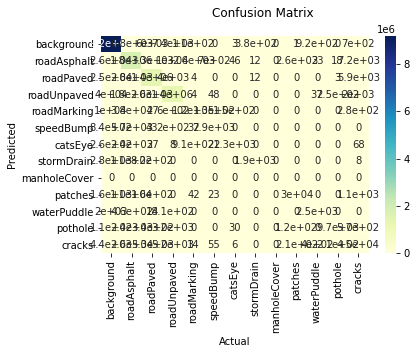

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f73ccf7f2d0>)

In [ ]:
gt_masks = gt_mask_iterator_from_dl(val_src)
pred_masks = pred_mask_iterator_from_dl(val_src, lambda img: learn.predict(img)[0])

eval = evaluate_segmentation(gt_masks, pred_masks, codes)
eval.show_confusion_matrix()

# Export ONNX

### Carregar Modelo: Opcional caso não tenha sido carregado ainda

In [ ]:
#learn = get_learner('best_model_155x506_stg2')

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


In [ ]:
sample_batch_size = 1
channel = 3
height = 288
width = 352
dummy_input = torch.randn(sample_batch_size, channel, height, width).cuda()

torch.onnx.export(learn.model, 
                  dummy_input, 
                  "/content/drive/MyDrive/Mestrado/Segmentação/HRNET/hrnet_w18_final.onnx",
                    verbose=True, opset_version=11,
                    export_params=True)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


graph(%input.1 : Float(1:304128, 3:101376, 288:352, 352:1, requires_grad=0, device=cuda:0),
      %head.3.weight : Float(13:270, 270:1, 1:1, 1:1, requires_grad=1, device=cuda:0),
      %head.3.bias : Float(13:1, requires_grad=1, device=cuda:0),
      %3547 : Float(64:27, 3:9, 3:3, 3:1, requires_grad=0, device=cuda:0),
      %3548 : Float(64:1, requires_grad=0, device=cuda:0),
      %3550 : Float(64:576, 64:9, 3:3, 3:1, requires_grad=0, device=cuda:0),
      %3551 : Float(64:1, requires_grad=0, device=cuda:0),
      %3553 : Float(64:64, 64:1, 1:1, 1:1, requires_grad=0, device=cuda:0),
      %3554 : Float(64:1, requires_grad=0, device=cuda:0),
      %3556 : Float(64:576, 64:9, 3:3, 3:1, requires_grad=0, device=cuda:0),
      %3557 : Float(64:1, requires_grad=0, device=cuda:0),
      %3559 : Float(256:64, 64:1, 1:1, 1:1, requires_grad=0, device=cuda:0),
      %3560 : Float(256:1, requires_grad=0, device=cuda:0),
      %3562 : Float(256:64, 64:1, 1:1, 1:1, requires_grad=0, device=cuda:0),


#Testes - Interpret+ConfunsionMatrix

Está resetando o notebook pela falta de memória ao gerar matriz de confusão - Lembrar de verificar isso

In [ ]:
data.loaders

1 parte do valid set

147942KB [00:10, 14747.36KB/s]                            


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.7/dist-packages/fastai/interpret.py:71: RuntimeWarning: invalid value encountered in true_divide
  if normalize: cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


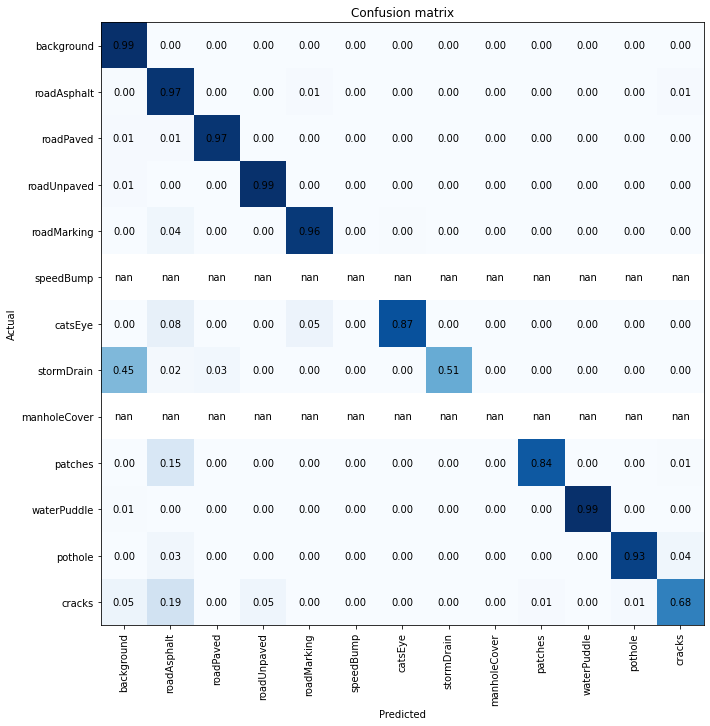

In [ ]:
#new_dl = data.test_dl(data.valid_ds.items[:1000], with_labels=True)
data.loaders.append(data.test_dl(data.valid_ds.items[:50], with_labels=True))
learn = get_learner('stg2')
interp = ClassificationInterpretation.from_learner(learn, ds_idx=2)
interp.plot_confusion_matrix(normalize=True,figsize=(15,10))

In [ ]:
part_one = interp.confusion_matrix()
part_one

array([[3584534,    6041,    4691,   13541,    1750,       0,      10,
             83,       0,      89,     130,      15,     586],
       [   2693,  671745,     249,     822,    5559,       0,     766,
             29,       0,    1319,      62,     622,    5884],
       [   2830,    2920,  265292,     481,      25,       0,       0,
             30,       0,      45,       0,       0,    1036],
       [   4299,     245,     241,  416804,     147,       2,       0,
              0,       0,       0,       0,      43,     492],
       [     39,    1155,       3,       0,   29770,       0,     125,
              0,       0,      18,       0,       0,       6],
       [      0,       0,       0,       0,       0,       0,       0,
              0,       0,       0,       0,       0,       0],
       [      0,     125,       0,       0,      87,       0,    1388,
              0,       0,       0,       0,       0,       0],
       [    395,      14,      26,       0,       0,       0, 

2 parte do valid set

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.7/dist-packages/fastai/interpret.py:71: RuntimeWarning: invalid value encountered in true_divide
  if normalize: cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


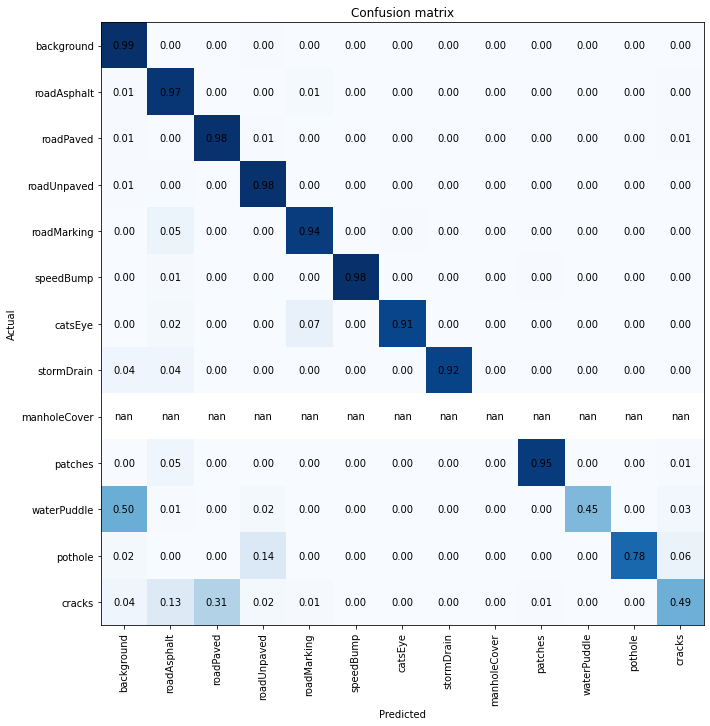

In [ ]:
data.loaders.append(data.test_dl(data.valid_ds.items[50:100], with_labels=True))
#learn = get_learner('stg2')
interp = ClassificationInterpretation.from_learner(learn, ds_idx=3)
interp.plot_confusion_matrix(normalize=True,figsize=(15,10))

In [ ]:
part_two = interp.confusion_matrix()
part_two

array([[3203387,    6502,    5053,   13209,    1971,     298,      17,
             78,       0,     420,     181,      52,     613],
       [   4504,  754799,    2540,     366,   11606,    1271,     374,
              1,       0,    1604,      41,       0,    3379],
       [   1755,     686,  297344,    1631,      31,       0,       2,
              9,       0,       3,       2,      25,    1614],
       [   4928,    2508,    2006,  633803,      39,       0,       0,
              0,       0,       0,     180,     980,     914],
       [     80,    2581,       0,       0,   47616,       0,     237,
              0,       0,       0,       0,       0,       3],
       [      0,      86,       0,       0,       0,    7727,       0,
              0,       0,      36,       0,       0,       0],
       [      0,      13,       0,       0,      47,       0,     601,
              0,       0,       0,       0,       0,       0],
       [      4,       4,       0,       0,       0,       0, 

3 parte do valid set

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.7/dist-packages/fastai/interpret.py:71: RuntimeWarning: invalid value encountered in true_divide
  if normalize: cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


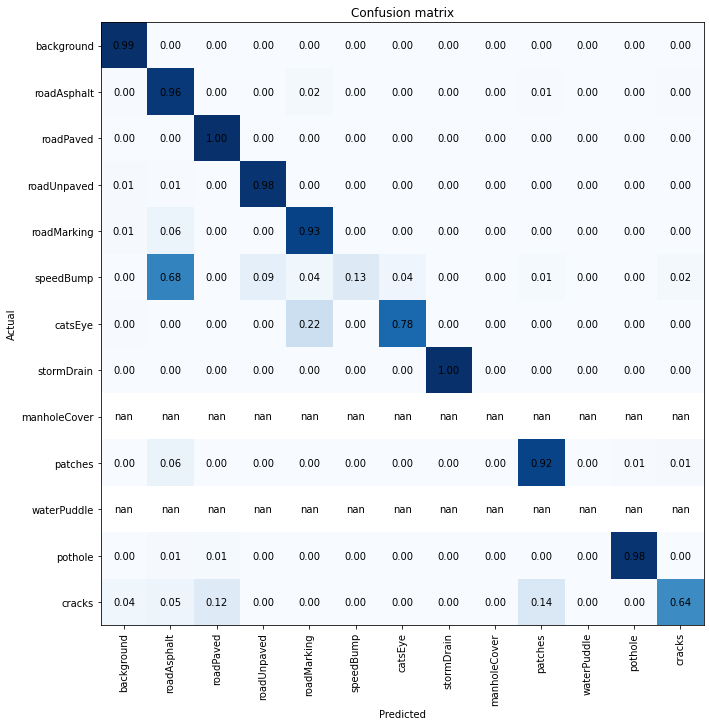

In [ ]:
data.loaders.append(data.test_dl(data.valid_ds.items[100:140], with_labels=True))
#learn = get_learner('stg2')
interp = ClassificationInterpretation.from_learner(learn, ds_idx=4)
interp.plot_confusion_matrix(normalize=True,figsize=(15,10))

In [ ]:
part_three = interp.confusion_matrix()
part_three

array([[2422659,    8022,    8927,    4719,     699,       0,      89,
            566,       0,     203,       9,       6,      12],
       [   1554,  371478,       3,     862,    7634,       4,     342,
              0,       0,    2125,       0,     475,    1593],
       [   2989,       0,  834678,       0,       0,       0,       6,
            281,       0,       0,       0,     298,       0],
       [   2729,    2082,     714,  314642,     194,    1145,       0,
              0,       0,       3,       0,       0,     281],
       [    441,    2452,       0,       0,   38486,       0,      91,
              0,       0,       0,       0,       0,     129],
       [      0,     723,       0,      92,      38,     135,      43,
              0,       0,      16,       0,       3,      18],
       [      1,       0,       0,       0,      54,       0,     195,
              0,       0,       0,       0,       0,       0],
       [      4,       0,       1,       0,       0,       0, 

In [ ]:
cm = (part_one + part_two + part_three)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


array([[9.91540464e-01, 2.21387031e-03, 2.00997679e-03, 3.38771140e-03,
        4.75823330e-04, 3.20803965e-05, 1.24876711e-05, 7.82632491e-05,
        0.00000000e+00, 7.66484641e-05, 3.44487479e-05, 7.85862062e-06,
        1.30366980e-04],
       [4.71420375e-03, 9.68602681e-01, 1.50406318e-03, 1.10434438e-03,
        1.33593348e-02, 6.86848336e-04, 7.98360183e-04, 1.61611373e-05,
        0.00000000e+00, 2.71938071e-03, 5.54865714e-05, 5.90958921e-04,
        5.84817689e-03],
       [5.35638640e-03, 2.55018872e-03, 9.88190349e-01, 1.49362135e-03,
        3.96035963e-05, 0.00000000e+00, 5.65765661e-06, 2.26306265e-04,
        0.00000000e+00, 3.39459397e-05, 1.41441415e-06, 2.28427886e-04,
        1.87409875e-03],
       [8.60502324e-03, 3.47986679e-03, 2.13110353e-03, 9.82602825e-01,
        2.73495219e-04, 8.25523725e-04, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 2.15917278e-06, 1.29550367e-04, 7.36277917e-04,
        1.21417483e-03],
       [4.54427421e-03, 5.02142301e-

([<matplotlib.axis.YTick at 0x7fbfae93f390>,
 [Text(0, 0, 'background'),
  Text(0, 0, 'roadAsphalt'),
  Text(0, 0, 'roadPaved'),
  Text(0, 0, 'roadUnpaved'),
  Text(0, 0, 'roadMarking'),
  Text(0, 0, 'speedBump'),
  Text(0, 0, 'catsEye'),
  Text(0, 0, 'stormDrain'),
  Text(0, 0, 'manholeCover'),
  Text(0, 0, 'patches'),
  Text(0, 0, 'waterPuddle'),
  Text(0, 0, 'pothole'),
  Text(0, 0, 'cracks')])

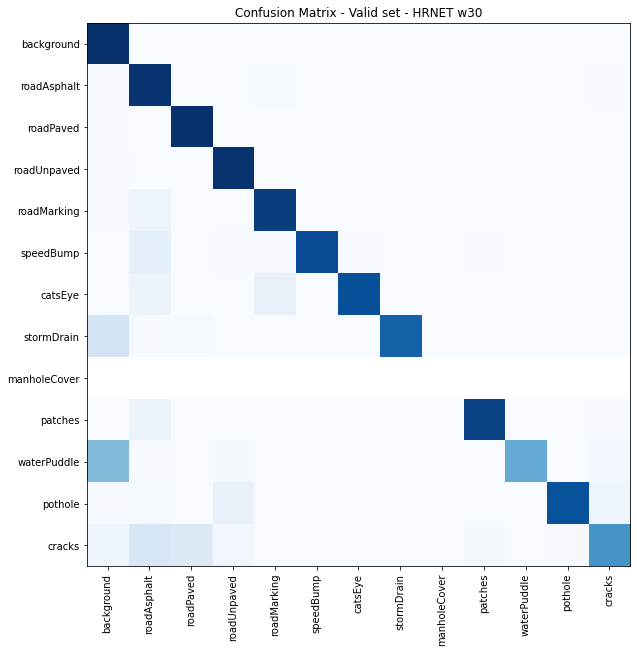

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15,10))
plt.imshow(cm, interpolation='nearest', cmap="Blues")
plt.title("Confusion Matrix - Valid set - HRNET w18")
tick_marks = np.arange(len(data.vocab))
plt.xticks(tick_marks, data.vocab, rotation=90)
plt.yticks(tick_marks, data.vocab, rotation=0)

In [ ]:
interp.most_confused(20)

[('background', 'roadPaved', 8927),
 ('background', 'roadAsphalt', 8022),
 ('roadAsphalt', 'roadMarking', 7634),
 ('background', 'roadUnpaved', 4719),
 ('roadPaved', 'background', 2989),
 ('roadUnpaved', 'background', 2729),
 ('roadMarking', 'roadAsphalt', 2452),
 ('roadAsphalt', 'patches', 2125),
 ('roadUnpaved', 'roadAsphalt', 2082),
 ('roadAsphalt', 'cracks', 1593),
 ('roadAsphalt', 'background', 1554),
 ('roadUnpaved', 'speedBump', 1145),
 ('roadAsphalt', 'roadUnpaved', 862),
 ('patches', 'roadAsphalt', 756),
 ('speedBump', 'roadAsphalt', 723),
 ('roadUnpaved', 'roadPaved', 714),
 ('cracks', 'patches', 700),
 ('background', 'roadMarking', 699),
 ('cracks', 'roadPaved', 594),
 ('background', 'stormDrain', 566),
 ('roadAsphalt', 'pothole', 475),
 ('roadMarking', 'background', 441),
 ('roadAsphalt', 'catsEye', 342),
 ('roadPaved', 'pothole', 298),
 ('roadPaved', 'stormDrain', 281),
 ('roadUnpaved', 'cracks', 281),
 ('cracks', 'roadAsphalt', 228),
 ('background', 'patches', 203),
 ('ro